Tutorial by [Depends on the definition
](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/)

A new paradigm in natural language processing (NLP) is to select a pre-trained model and then “fine-tuning” the model with new data from your specific task.

BERT is a powerful general-purpose language model trained on “masked language modeling” that can be leveraged for the text-based machine learning tasks.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
#!pip3 install awscli awsebcli botocore==1.18.18 --upgrade

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
"""# Set the seed value all over the place to make this reproducible.
import random
import numpy as np
import torch

seed_val = 2353

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)"""

'# Set the seed value all over the place to make this reproducible.\nimport random\nimport numpy as np\nimport torch\n\nseed_val = 2353\n\nrandom.seed(seed_val)\nnp.random.seed(seed_val)\ntorch.manual_seed(seed_val)\ntorch.cuda.manual_seed_all(seed_val)'

In [ ]:
# The token can be used to access the repository
!git clone https://github.com/cariello1/BIO-NER-.git

Cloning into 'BIO-NER-'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 435 (delta 40), reused 0 (delta 0), pack-reused 365
Receiving objects: 100% (435/435), 12.42 MiB | 20.03 MiB/s, done.
Resolving deltas: 100% (226/226), done.


In [ ]:
%cd /content/BIO-NER-

/content/BIO-NER-


In [ ]:
from preprocessing_1 import PreprocessingDocsNN
from preprocessing_1 import read_data

# TRANSFORMERS

In [ ]:
%%capture
!pip3 install transformers==2.6.0

In [ ]:
"""!git clone https://github.com/huggingface/transformers.git
!cd transformers
!pip install -e ."""

'!git clone https://github.com/huggingface/transformers.git\n!cd transformers\n!pip install -e .'

# PREPROCESSING

In [ ]:
import numpy as np
import codecs
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow

In [ ]:
# For reproducibility
seed = 768
tf.random.set_seed(seed)

In [ ]:
# Original data in IOB format
file1_train = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/train.tsv"
file2_test = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/test.tsv"
file3_dev = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/devel.tsv"

In [ ]:
input_train = read_data(file1_train)
input_test = read_data(file2_test)
input_dev = read_data(file3_dev)

Total number of sentences: 30682 
Total number of sentences: 26364 
Total number of sentences: 30639 


In [ ]:
docs_train = PreprocessingDocsNN(input_train)
docs_test = PreprocessingDocsNN(input_test)
docs_dev = PreprocessingDocsNN(input_dev)

In [ ]:
# First sentence of dataset with both words and labels
print('This is what a sentence looks like:{}'.format(input_train[0]))

This is what a sentence looks like:[('DPP6', 'O'), ('as', 'O'), ('a', 'O'), ('candidate', 'O'), ('gene', 'O'), ('for', 'O'), ('neuroleptic', 'O'), ('-', 'O'), ('induced', 'O'), ('tardive', 'O'), ('dyskinesia', 'O'), ('.', 'O')]


In [ ]:
print("\033[1m"+"Statistics for the train set:"+'\033[0m')
print("Number of sentences: {}".format(len(docs_train.sentences)))
print("Number of tokens: {}".format(len(docs_train.tokens)))
print("Size of vocabulary: {}".format(len(docs_train.vocabulary)))
print('Tagset:', ' '.join(docs_train.tagset))
print("Number of Tags {}".format(len(docs_train.tagset)))

Statistics for the train set:
Number of sentences: 30682
Number of tokens: 891948
Size of vocabulary: 40528
Tagset: B-Chemical O I-Chemical
Number of Tags 3


# DATA VISUALIZATION

In [ ]:
sentences_len = np.array([len(s) for s in docs_train.sentences]) #list with len for each sents

In [ ]:
sen_mean = np.round(sentences_len.mean()).astype(int) 

In [ ]:
max_seq_len = 50 #timesteps

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


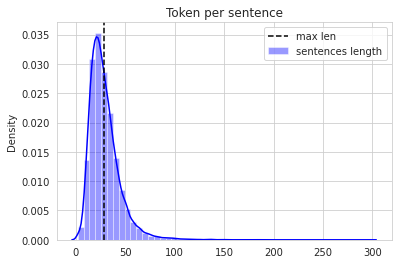

In [ ]:
sns.distplot(sentences_len, hist=True, kde=True, color="b", label="sentences length")
plt.axvline(x=sen_mean, color="k", linestyle="--", label="max len")
plt.title("Token per sentence")
plt.legend()
plt.show()

In [ ]:
sent_less_than_msl = [s for s in docs_train.sentences if len(s) <= 50]
perc_sent = round(len(sent_less_than_msl) / len(docs_train.sentences) * 100)
print("The", perc_sent,"%", "of sentences has less or equal than 50 tokens.")

The 92 % of sentences has less or equal than 50 tokens.


# PREPROCESSING FOR DP TRAINING

In [ ]:
# Vocabulary Key:Tag -> Value:ID_tag & Vocabulary Key:ID_tag -> Value:Tag
tag2idx, idx2tag = docs_train.from_labels_2_idx()

In [ ]:
# Padding and encoding the target variable
y_train = docs_train.padded_and_encoded_labels(tag2idx, max_seq_len)
y_test = docs_test.padded_and_encoded_labels(tag2idx, max_seq_len)

In [ ]:
# Padding and encoding the target variable
y_train = docs_train.padded_and_encoded_labels(tag2idx, max_seq_len)
y_test = docs_test.padded_and_encoded_labels(tag2idx, max_seq_len)
y_dev = docs_dev.padded_and_encoded_labels(tag2idx, max_seq_len)

In [ ]:
# Decoding one-hot vectors
y_train = np.argmax(y_train, axis = -1)
y_test = np.argmax(y_test, axis = -1)
y_dev = np.argmax(y_dev, axis = -1)

In [ ]:
tag2idx

{'B-Chemical': 1, 'I-Chemical': 3, 'O': 2, 'PAD': 0}

In [ ]:
idx2tag

{0: 'PAD', 1: 'B-Chemical', 2: 'O', 3: 'I-Chemical'}

# PREPARING DATA FOR BERT

Before we can start *fine-tuning* the model, we have to prepare the data set for the use with pytorch and BERT.

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.8.0+cu101'

Here we fix some configurations. We will limit our sequence length to 50 tokens and we will use a batch size of 32 as suggested by the Bert paper. Note, that Bert supports sequences of up to 512 tokens.

In [ ]:
bs = 32

In [ ]:
print(torch.cuda.device_count()) 

1


In [ ]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case=False)

Since the BERT tokenizer is based on wordpiece tokenizer it will split tokens in subword tokens. For example ‘dexamethasone’ will be split in five tokens: ‘de’, ‘##xa’, ‘##met’, ‘##has’, ‘##one’. 
We have to deal with the issue of splitting token-level labels to related subtokens.

In [ ]:
docs_train.data[0]

[('DPP6', 'O'),
 ('as', 'O'),
 ('a', 'O'),
 ('candidate', 'O'),
 ('gene', 'O'),
 ('for', 'O'),
 ('neuroleptic', 'O'),
 ('-', 'O'),
 ('induced', 'O'),
 ('tardive', 'O'),
 ('dyskinesia', 'O'),
 ('.', 'O')]

In [ ]:
tokenized_sentence = []
labels = []

for s in docs_train.data:
  tokens = []
  lab = []
  for word, label in s:
    tokenized_word = tokenizer.tokenize(word) #BERT tokenizer
    n_subwords = len(tokenized_word)

    # Add the tokenized word to the final tokenized word list
    tokens.extend(tokenized_word)

    # Add the same label to the new list of labels `n_subwords` times
    lab.extend([label] * n_subwords)
  tokenized_sentence.append(tokens)
  labels.append(lab)

In [ ]:
tokenized_sentence_test = []
labels_test = []

for s in docs_test.data:
  tokens = []
  lab = []
  for word, label in s:
    tokenized_word = tokenizer.tokenize(word) #BERT tokenizer
    n_subwords = len(tokenized_word)

    # Add the tokenized word to the final tokenized word list
    tokens.extend(tokenized_word)

    # Add the same label to the new list of labels `n_subwords` times
    lab.extend([label] * n_subwords)
  tokenized_sentence_test.append(tokens)
  labels_test.append(lab)

In [ ]:
tokenized_sentence_dev = []
labels_dev = []

for s in docs_dev.data:
  tokens = []
  lab = []
  for word, label in s:
    tokenized_word = tokenizer.tokenize(word) #BERT tokenizer
    n_subwords = len(tokenized_word)

    # Add the tokenized word to the final tokenized word list
    tokens.extend(tokenized_word)

    # Add the same label to the new list of labels `n_subwords` times
    lab.extend([label] * n_subwords)
  tokenized_sentence_dev.append(tokens)
  labels_dev.append(lab)

PADDING

Next, we cut and pad the token and label sequences to our desired length.

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_sentence],
                          maxlen=max_seq_len, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_sentence_test],
                          maxlen=max_seq_len, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
input_ids_dev = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_sentence_dev],
                          maxlen=max_seq_len, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
# Converting sublabels
tags = [[tag2idx.get(l) for l in lab] for lab in labels]

In [ ]:
tags_test = [[tag2idx.get(l) for l in lab] for lab in labels_test]

In [ ]:
tags_dev = [[tag2idx.get(l) for l in lab] for lab in labels_dev]

PADDING LABELS

In [ ]:
tags = pad_sequences(tags,
                     maxlen=max_seq_len, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
tags_test = pad_sequences(tags_test,
                     maxlen=max_seq_len, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
tags_dev = pad_sequences(tags_dev,
                     maxlen=max_seq_len, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
tags[0]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

The mask tensor allows the model to ignore the padded elements in the sequences.

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
attention_masks_test = [[float(i != 0.0) for i in ii] for ii in input_ids_test]

In [ ]:
attention_masks_dev = [[float(i != 0.0) for i in ii] for ii in input_ids_dev]

In [ ]:
#attention_masks[0]

# SPLITTING TRAIN AND VALIDATION SET

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
tr_inputs[0]

array([ 1188,  3606, 11363, 19540,  1104,  3908, 18091,   140,  1161,
        1477,   116,  1194,  1664,   118, 10323,   118,  5400,  1181,
        1105, 27453,  1477,   116,   118,  3510,  1895,   140,  1161,
        1477,   116,  6412,  1104,  1103, 13441, 10936,   119,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

Since we’re operating in pytorch, we have to convert the dataset to torch tensors.

In [ ]:
# Make tensors for training
tr_inputs = torch.tensor(input_ids)
val_inputs = torch.tensor(input_ids_dev)
tr_tags = torch.tensor(tags)
val_tags = torch.tensor(tags_dev)
tr_masks = torch.tensor(attention_masks)
val_masks = torch.tensor(attention_masks_dev)

In [ ]:
# Make tensors for testing
test_input =  torch.tensor(input_ids_test)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
test_data = TensorDataset(test_input, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = SequentialSampler(train_data) # proviamo sequentialSampler
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [ ]:
train_dataloader.dataset.tensors

(tensor([[  141, 20923,  1545,  ...,     0,     0,     0],
         [ 1284,  7042,   170,  ...,     0,     0,     0],
         [ 1752,   117,  1195,  ..., 15439,   119,     0],
         ...,
         [ 2156, 18305,  1104,  ...,     0,     0,     0],
         [16752, 14669,  1174,  ...,     0,     0,     0],
         [ 3458,  2686,  5996,  ...,     0,     0,     0]]),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([[2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 2, 2, 0],
         ...,
         [2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0]]))

# MODEL FINE-TUNING

The transformer package provides a BertForTokenClassification class for token-level predictions. BertForTokenClassification is a fine-tuning model that wraps BertModel and adds a token-level classifier on top of the BertModel. The token-level classifier is a linear layer that takes as input the last hidden state of the sequence. We load the pre-trained bert-base-cased model and provide the number of possible labels.



In [ ]:
# https://pypi.org/project/adamp/
#!pip install adamp --upgrade 

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'2.6.0'

In [ ]:
# Load pretrained BertForTokenClassification model
model = BertForTokenClassification.from_pretrained(
    "bert-large-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False,
    force_download = True

)

In [ ]:
%%capture
model.cuda()

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters, 
    lr=5e-5,
    #eps=1e-8
)

We also add a scheduler to linearly reduce the learning rate throughout the epochs.


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# TRAINING

In [ ]:
%%capture
!pip3 install seqeval

In [ ]:
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange

In [ ]:
output_dir = "/content/drive/MyDrive/BIO-NER-project"

In [ ]:
import os

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
valid_f1_prev = 0
for epoch in trange(epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()


    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [[idx2tag[p_i] for p_i,l_i in zip(p, l) if idx2tag[l_i] != "PAD"] for p,l in zip(predictions, true_labels)]
    valid_tags = [[idx2tag[l_i] for l_i in s if idx2tag[l_i] != "PAD"] for s in true_labels ]
    valid_acc = accuracy_score(pred_tags, valid_tags)
    valid_f1 = f1_score(pred_tags, valid_tags)

    print("Validation Accuracy: {}".format(valid_acc))
    print("Validation F1-Score: {}".format(valid_f1))
    print()

    # Save model with best F1 on validation set
    if valid_f1 > valid_f1_prev:
        # model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
        torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'valid_acc': valid_acc,
    'valid_f1': valid_f1, 'max_seq_length': max_seq_len},  # Save a checkpoint
            os.path.join(output_dir, 'ner_bert_checkpoint_BC4CHEMDNER.pt'))
        valid_f1_prev = valid_f1

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Average train loss: 0.10670633709071033
Validation loss: 0.06430704893941927
Validation Accuracy: 0.9776334083594755
Validation F1-Score: 0.859868234913706



 33%|███▎      | 1/3 [11:18<22:37, 678.90s/it]

Average train loss: 0.036815680946321525
Validation loss: 0.061918374275199174
Validation Accuracy: 0.9825965815406148
Validation F1-Score: 0.8911014642823953



 67%|██████▋   | 2/3 [22:33<11:17, 677.65s/it]

Average train loss: 0.015810236589413714
Validation loss: 0.06423426525027542
Validation Accuracy: 0.9841060287413519
Validation F1-Score: 0.8986632460167433



100%|██████████| 3/3 [33:46<00:00, 675.64s/it]


# EVAL VISUALIZATION ON VALIDATION SET

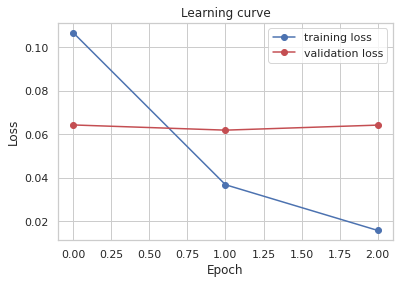

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='whitegrid')

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
from seqeval.metrics import classification_report

print(classification_report(pred_tags, valid_tags))

              precision    recall  f1-score   support

    Chemical       0.91      0.89      0.90     74789

   micro avg       0.91      0.89      0.90     74789
   macro avg       0.91      0.89      0.90     74789
weighted avg       0.91      0.89      0.90     74789



# PREDICTION ON INDIPENDENT TEST SET

In [ ]:
X_test = docs_test.sentences

In [ ]:
input_ids_test1 = torch.tensor(input_ids_test).cuda()

In [ ]:
input_ids_test1

tensor([[23009,  1104,  1202,  ...,     0,     0,     0],
        [ 9425,  2515,  1241,  ...,     0,     0,     0],
        [21991,  1193,   117,  ...,     0,     0,     0],
        ...,
        [ 1438,   117,  1292,  ...,     0,     0,     0],
        [ 7642,  2155,  7880,  ...,  1477,  2036, 21392],
        [ 5055,  1179,  1487,  ...,     0,     0,     0]], device='cuda:0')

In [ ]:
# Load model checkpoint
checkpoint = torch.load(output_dir+'/ner_bert_checkpoint_BC4CHEMDNER.pt', map_location='cpu')

epoch = checkpoint['epoch']
valid_acc_prev = checkpoint['valid_acc']
valid_f1_prev = checkpoint['valid_f1']

model = BertForTokenClassification.from_pretrained("bert-large-cased", state_dict=checkpoint['model_state'], num_labels=len(tag2idx))
model.to(device)
print('Loaded the pretrained BERT model, epoch:',checkpoint['epoch'],'valid acc:', round(checkpoint['valid_acc'], 3), 'valid f1:', round(checkpoint['valid_f1'], 3))


Loaded the pretrained BERT model, epoch: 2 valid acc: 0.984 valid f1: 0.899


In [ ]:
predictions = []

with torch.no_grad():
  for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    outputs = model(b_input_ids, attention_mask=b_input_mask)
    _, predicted = torch.max(outputs[0], -1)
    predictions.extend(predicted.tolist())

In [ ]:
converted = []
for sent in input_ids_test1:
  sent1 = tokenizer.convert_ids_to_tokens(sent.to('cpu'))
  converted.append(sent1)

In [ ]:
converted[0]

['Effects',
 'of',
 'do',
 '##cos',
 '##ah',
 '##ex',
 '##aen',
 '##oi',
 '##c',
 'acid',
 'and',
 'met',
 '##hyl',
 '##mer',
 '##cu',
 '##ry',
 'on',
 'child',
 "'",
 's',
 'brain',
 'development',
 'due',
 'to',
 'consumption',
 'of',
 'fish',
 'by',
 'Finnish',
 'mother',
 'during',
 'pregnancy',
 ':',
 'a',
 'pro',
 '##ba',
 '##bil',
 '##istic',
 'modeling',
 'approach',
 '.',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

# POST-PROCESSING

In [ ]:
# Take track of original tokenization appending original indices in a list

list_tok_to_orig = []
list_all_tok = []
list_orig_to_tok = []
for s in docs_test.sentences:
  tok_to_orig_index = []
  orig_to_tok_index = []
  all_doc_tokens = []
  for (i, token) in enumerate(s):
    orig_to_tok_index.append(len(all_doc_tokens))
    sub_tokens = tokenizer.tokenize(token)
    for sub_token in sub_tokens:
      tok_to_orig_index.append(i)
      all_doc_tokens.append(sub_token)
  list_tok_to_orig.append(tok_to_orig_index)
  list_all_tok.append(all_doc_tokens)
  list_orig_to_tok.append(orig_to_tok_index)

In [ ]:
# Original index, token, prediction_tag
for i, token, l in zip(list_tok_to_orig[0], list_all_tok[0], predictions[0]):
  print(i, token, l)

0 Effects 2
1 of 2
2 do 1
2 ##cos 1
2 ##ah 1
2 ##ex 1
2 ##aen 1
2 ##oi 1
2 ##c 1
3 acid 3
4 and 2
5 met 1
5 ##hyl 1
5 ##mer 1
5 ##cu 1
5 ##ry 1
6 on 2
7 child 2
8 ' 2
9 s 2
10 brain 2
11 development 2
12 due 2
13 to 2
14 consumption 2
15 of 2
16 fish 2
17 by 2
18 Finnish 2
19 mother 2
20 during 2
21 pregnancy 2
22 : 2
23 a 2
24 pro 2
24 ##ba 2
24 ##bil 2
24 ##istic 2
25 modeling 2
26 approach 2
27 . 2


In [ ]:
# Detokenization : Restore the original token sequences

original_test_sentence, y_hat, y_true = [], [], []
for sent, i, lidx, lidtrue in zip(list_all_tok, list_tok_to_orig, predictions, tags_test):
  position = None
  new_tokens, new_labels_hat, new_labels_true = [], [], []
  for token, j, label_idx, label_idx_true in zip(sent, i, lidx, lidtrue):
    if position == j:
      new_tokens[-1] = new_tokens[-1] + token
    else:
      new_labels_hat.append(idx2tag[label_idx])
      new_labels_true.append(idx2tag[label_idx_true])
      new_tokens.append(token)
      position = j
  original_test_sentence.append(new_tokens)
  original_test_sentence = [[item.replace("##", "") for item in s] for s in original_test_sentence]
  y_hat.append(new_labels_hat)
  y_true.append(new_labels_true)

In [ ]:
y_hat[0]

['O',
 'O',
 'B-Chemical',
 'I-Chemical',
 'O',
 'B-Chemical',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
y_true[0]

['O',
 'O',
 'B-Chemical',
 'I-Chemical',
 'O',
 'B-Chemical',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
original_test_sentence[0]

['Effects',
 'of',
 'docosahexaenoic',
 'acid',
 'and',
 'methylmercury',
 'on',
 'child',
 "'",
 's',
 'brain',
 'development',
 'due',
 'to',
 'consumption',
 'of',
 'fish',
 'by',
 'Finnish',
 'mother',
 'during',
 'pregnancy',
 ':',
 'a',
 'probabilistic',
 'modeling',
 'approach',
 '.']

# EVAL ON TEST SET

In [ ]:
print('\033[1m' + "Classification report for BERT: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

Classification report for BERT: 

              precision    recall  f1-score   support

    Chemical       0.88      0.88      0.88     22336

   micro avg       0.88      0.88      0.88     22336
   macro avg       0.88      0.88      0.88     22336
weighted avg       0.88      0.88      0.88     22336



In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

F1-score(relaxed): 0.88


In [ ]:
from seqeval.scheme import IOB2
print('\033[1m' + "Classification report for BERT: ")
print('\033[0m')
print(classification_report(y_true, y_hat,scheme=IOB2, mode="strict"))

Classification report for BERT: 

              precision    recall  f1-score   support

    Chemical       0.89      0.87      0.88     22336

   micro avg       0.89      0.87      0.88     22336
   macro avg       0.89      0.87      0.88     22336
weighted avg       0.89      0.87      0.88     22336



In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict"))

# COMPARE RESULTS

In [ ]:
i = 18
print("{:15} {:5}: ({})".format("Word", "True", "Pred"))
print("="*45)
for w, true, pred in zip(original_test_sentence[i], y_true[i], y_hat[i]):
  print("{:15}:{:15} ({})".format(w, true, pred))

Word            True : (Pred)
Endothelial    :O               (O)
nitric         :B-Chemical      (B-Chemical)
oxide          :I-Chemical      (I-Chemical)
synthase       :O               (O)
genotypes      :O               (O)
and            :O               (O)
haplotypes     :O               (O)
modify         :O               (O)
the            :O               (O)
responses      :O               (O)
to             :O               (O)
sildenafil     :B-Chemical      (B-Chemical)
in             :O               (O)
patients       :O               (O)
with           :O               (O)
erectile       :O               (O)
dysfunction    :O               (O)
.              :O               (O)


#  LR OPTIMIZATION

In [ ]:
%%capture
!pip install torch-lr-finder

In [ ]:
from torch_lr_finder import LRFinder

In [ ]:
"""train_data = TensorDataset(tr_inputs, tr_tags)
train_dataloader = DataLoader(train_data, batch_size=bs)"""

In [ ]:
model.parameters()

In [ ]:
train_dataloader

In [ ]:
import torch.nn as nn
class LossWrapper(nn.Module):
    def __init__(self, loss_fn):
        super().__init__()
        self.loss_fn = loss_fn

    def forward(self, outputs, labels):
        logits = outputs[1]  # logits only
        return self.loss_fn(logits, labels.view(-1))

In [ ]:
"""# Then, just replace the original criterion with this wrapper
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
criterion = LossWrapper(nn.CrossEntropyLoss())
lr_finder = LRFinder(model, optimizer2, criterion, device="cpu")
lr_finder.range_test(train_dataloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state"""

# REPORT2

In [ ]:
print('\033[1m' + "Classification report for #2 model with LR optimization: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

In [ ]:
import sys

print('Saving classification report on file...')

original_stdout = sys.stdout 

with open('/content/drive/MyDrive/output.txt', 'a') as f:
  sys.stdout = f # Change the standard output to the file we created.
  print('\033[1m' + "Classification report BERT model for BC4CHEMD dataset: ")
  print('\033[0m')
  print(classification_report(y_true, y_hat))
  sys.stdout = original_stdout # Reset the standard output to its original value
print("Done.")